In [ ]:
!pip install segmentation_models
!cat /usr/local/lib/python3.11/dist-packages/efficientnet/keras.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.6 MB/s eta 0:00:00
from . import inject_keras_modules, init_keras_custom_objects
from . import model

from .preprocessing import center_crop_and_resize

EfficientNetB0 = inject_keras_modules(model.EfficientNetB0)
EfficientNetB1 = inject_keras_modules(model.EfficientNetB1)
EfficientNetB2 = inject_keras_modules(model.EfficientNetB2)
EfficientNetB3 = inject_keras_modules(model.EfficientNetB3)
EfficientNetB4 = inject_keras_modules(model.EfficientNetB4)
EfficientNetB5 = inject_keras_modules(model.EfficientNetB5)
EfficientNetB6 = inject_keras_modules(model.EfficientNetB6)
EfficientNetB7 = inject_keras_modules(model.EfficientNetB7)

preprocess_input = inject_keras_modules(model.preprocess_input)

init_keras_custom_objects()


In [ ]:
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

print(tf.__version__)


Segmentation Models: using `keras` framework.
2.18.0


In [ ]:
tf.keras.backend.clear_session()
tf.config.experimental.reset_memory_stats('GPU:0')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import files

# Upload a folder (this will only allow you to upload files inside the folder)
uploaded = files.upload()

In [ ]:
import zipfile
import os

# Unzip the uploaded file
frame_zip_file = '/content/drive/MyDrive/RUGD_frames-with-annotations.zip'
annotation_zip_file = '/content/drive/MyDrive/RUGD_annotations.zip'
zip_dir = '/content/'

with zipfile.ZipFile(frame_zip_file, 'r') as zip_ref:
    zip_ref.extractall(zip_dir)

with zipfile.ZipFile(annotation_zip_file, 'r') as zip_ref:
    zip_ref.extractall(zip_dir)

In [ ]:
%cd /content/
!ls

/content
drive  RUGD_annotations  RUGD_frames-with-annotations  sample_data


In [ ]:
!# Define the color map
color_map = {
    0: [0, 0, 0],                # void
    1: [108, 64, 20],            # dirt
    2: [255, 229, 204],          # sand
    3: [0, 102, 0],              # grass
    4: [0, 255, 0],              # tree
    5: [0, 153, 153],            # pole
    6: [0, 128, 255],            # water
    7: [0, 0, 255],              # sky
    8: [255, 255, 0],            # vehicle
    9: [255, 0, 127],            # container/generic-object
    10: [64, 64, 64],            # asphalt
    11: [255, 128, 0],           # gravel
    12: [255, 0, 0],             # building
    13: [153, 76, 0],            # mulch
    14: [102, 102, 0],           # rock-bed
    15: [102, 0, 0],             # log
    16: [0, 255, 128],           # bicycle
    17: [204, 153, 255],         # person
    18: [102, 0, 204],           # fence
    19: [255, 153, 204],         # bush
    20: [0, 102, 102],           # sign
    21: [153, 204, 255],         # rock
    22: [102, 255, 255],         # bridge
    23: [101, 101, 11],          # concrete
    24: [114, 85, 47]            # picnic-table
}

# Create a reverse lookup to map colors to class labels
color_to_class = {tuple(value): key for key, value in color_map.items()}

def color_to_class_label(mask):
    # Convert mask to a 2D array where each pixel value is represented by an RGB tuple
    mask_rgb = mask.reshape(-1, 3)  # Reshape to a 2D array where each row is an RGB pixel

    # Map RGB values to class labels
    label_mask = np.array([color_to_class.get(tuple(rgb), 0) for rgb in mask_rgb])

    # Reshape back to the original mask shape (height, width)
    label_mask = label_mask.reshape(mask.shape[0], mask.shape[1])

    return label_mask

# def color_to_class_label(mask):
#     # Create an empty label mask
#     label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int32)  # Use np.int32 instead of np.long

#     # For each pixel, get the RGB value and map it to the class label
#     for i in range(mask.shape[0]):
#         for j in range(mask.shape[1]):
#             rgb_value = tuple(mask[i, j])
#             if rgb_value in color_to_class:
#                 label_mask[i, j] = color_to_class[rgb_value]
#             else:
#                 label_mask[i, j] = 0  # Default to class 0 if color is not found

#     return label_mask

In [ ]:
# Paths
IMG_DIR = "/content/RUGD_frames-with-annotations"
MASK_DIR = "/content/RUGD_annotations"

IMG_SIZE = (384, 320)
NUM_CLASSES = 25  # Cityscapes has 19 semantic classes
BATCH_SIZE = 8  # Reduce batch size if kernel still crashes


# 🔹 **Get List of Files & Split Data**
def get_data_splits(test_size=0.1, val_size=0.1):
    img_files = []

    for root, _, files in os.walk(IMG_DIR):
        for file in files:
            if file.endswith('.png'):
                img_files.append(os.path.join(root, file))

    img_files.sort()  # Ensure consistency
    np.random.shuffle(img_files)  # Shuffle dataset

    # Split into train, validation, and test
    train_files, test_files = train_test_split(img_files, test_size=test_size, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=val_size / (1 - test_size), random_state=42)

    return train_files, val_files, test_files

# 🔹 **Function to Load Single Image**
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize
    return img

# 🔹 **Function to Load Single Mask**
def load_mask(mask_path):
    mask = cv2.imread(mask_path)
    mask_resized = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)

    label_mask = color_to_class_label(mask_resized)

    return label_mask.astype(np.int32)  # Keep as integers (not one-hot)

# 🔹 **Dataset Generator**
def rugd_generator(file_list):
    for img_path in file_list:
        mask_path = os.path.join(MASK_DIR, os.path.relpath(img_path, IMG_DIR))


        # 🔹 Check if files exist before processing
        if not os.path.exists(mask_path):
            print(f"⚠️ Skipping - Mask file not found: {mask_path}")
            continue

        img = load_image(img_path)
        mask = load_mask(mask_path)

        yield img, mask


# 🔹 **Convert Generator to `tf.data.Dataset`**
def get_rugd_dataset(file_list, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_generator(
        lambda: rugd_generator(file_list),
        output_signature=(
            tf.TensorSpec(shape=(IMG_SIZE[1], IMG_SIZE[0], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(IMG_SIZE[1], IMG_SIZE[0]), dtype=tf.int32)
        )
    )

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Optimize performance
    return dataset

# 🔹 **Create Train, Validation & Test Datasets**
train_files, val_files, test_files = get_data_splits()

print(f"Total images: {len(train_files) + len(val_files) + len(test_files)}")
print(f"Train set: {len(train_files)} images")
print(f"Validation set: {len(val_files)} images")
print(f"Test set: {len(test_files)} images")


train_dataset = get_rugd_dataset(train_files)
val_dataset = get_rugd_dataset(val_files)
test_dataset = get_rugd_dataset(test_files)


Total images: 7436
Train set: 5948 images
Validation set: 744 images
Test set: 744 images


In [ ]:
from tensorflow.keras.metrics import MeanIoU

# Ensure compatibility with TensorFlow 2.x
sm.set_framework("tf.keras")

# Set backbone (EfficientNet or ResNet)
BACKBONE = "efficientnetb3"  # Try 'resnet50' for ResNet backbone

# Load Pretrained U-Net (or PSPNet, FPN)
model = sm.Unet(BACKBONE,
                encoder_weights="imagenet",
                classes=25,
                activation="softmax",
                input_shape=(IMG_SIZE[1], IMG_SIZE[0], 3)
               )

# Freeze ALL layers initially
for layer in model.layers:
    layer.trainable = False

# Unfreeze only the decoder
for layer in model.layers:
    if "decoder" in layer.name or "final_conv" in layer.name or "softmax" in layer.name:
        layer.trainable = True  # Fine-tune decoder

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", MeanIoU(num_classes=25, sparse_y_pred=False)]
              )

model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 320, 384, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 160, 192, 40)   │          1,080 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 160, 192, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 160, 192, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 160, 192, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 160, 192, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 160, 192, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 40)       │            440 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 160, 192, 40)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 160, 192, 24)   │            960 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn   

 Total params: 17,871,313 (68.17 MB)

 Trainable params: 7,085,801 (27.03 MB)

 Non-trainable params: 10,785,512 (41.14 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping: Stop if val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor="val_mean_io_u_1",  # Track validation loss
    patience=2,  # Stop after 2 epochs of no improvement
    verbose=1,
    restore_best_weights=True  # Restore best weights
)

# Model Checkpoint: Save the best model based on validation IoU
checkpoint = ModelCheckpoint(
    "best_RUGD_model_Last_Layer.keras",  # File name
    monitor="val_mean_io_u_1",  # Track MeanIoU
    save_best_only=True,  # Save only the best model
    mode="max",  # Maximize IoU
    verbose=1
)

# Add Callbacks to Training
callbacks = [early_stopping, checkpoint]

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
    744/Unknown 3675s 5s/step - accuracy: 0.7027 - loss: 1.4906 - mean_io_u_1: 0.1406

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_mean_io_u_1 improved from -inf to 0.46820, saving model to best_RUGD_model_Last_Layer.keras
744/744 ━━━━━━━━━━━━━━━━━━━━ 4141s 6s/step - accuracy: 0.7028 - loss: 1.4899 - mean_io_u_1: 0.1407 - val_accuracy: 0.8761 - val_loss: 0.4520 - val_mean_io_u_1: 0.4682
Epoch 2/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8716 - loss: 0.4587 - mean_io_u_1: 0.4749
Epoch 2: val_mean_io_u_1 improved from 0.46820 to 0.57497, saving model to best_RUGD_model_Last_Layer.keras
744/744 ━━━━━━━━━━━━━━━━━━━━ 4097s 6s/step - accuracy: 0.8716 - loss: 0.4587 - mean_io_u_1: 0.4750 - val_accuracy: 0.9007 - val_loss: 0.3320 - val_mean_io_u_1: 0.5750
Epoch 3/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8989 - loss: 0.3388 - mean_io_u_1: 0.5717
Epoch 3: val_mean_io_u_1 improved from 0.57497 to 0.60006, saving model to best_RUGD_model_Last_Layer.keras
744/744 ━━━━━━━━━━━━━━━━━━━━ 4097s 6s/step - accuracy: 0.8989 - loss: 0.3387 - mean_io_u_1: 0.5717 - val_accuracy: 0.9108 - val_lo

In [ ]:
!cp /content/best_RUGD_model_Last_Layer.keras /content/drive/MyDrive/

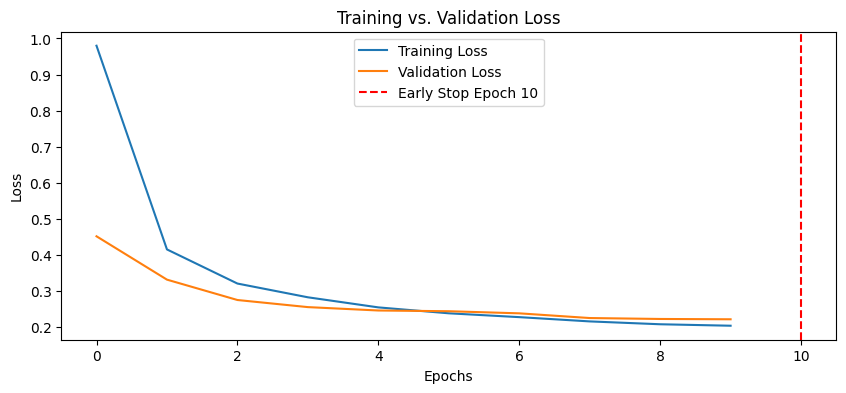

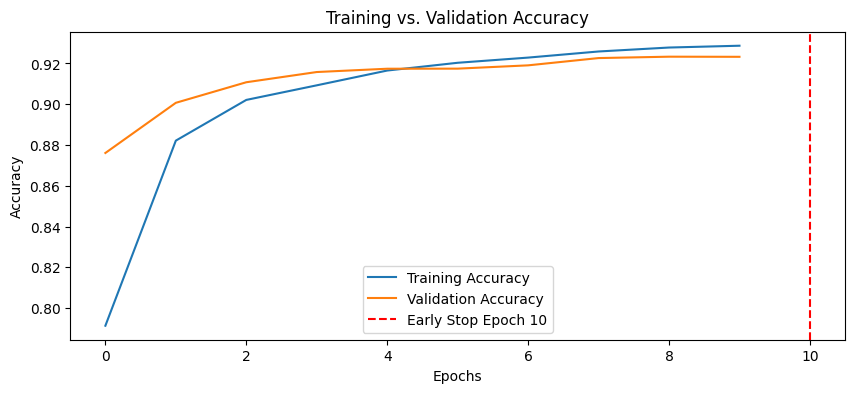

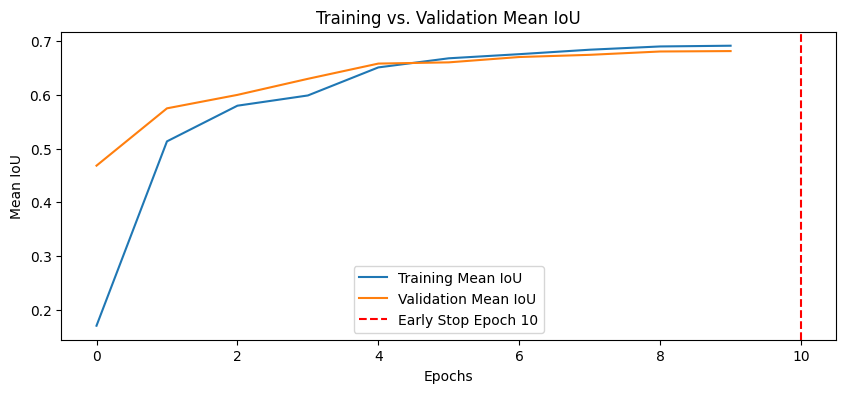

In [21]:
# Plot training vs validation loss, accuracy and mean IOU

# Extract training history
epochs = range(len(history.history["loss"]))

# Identify the epoch where early stopping occurred
best_epoch = np.argmax(history.history["val_mean_io_u_1"])+1  # Epoch with highest validation mean IOU


# Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, history.history["loss"], label="Training Loss")
plt.plot(epochs, history.history["val_loss"], label="Validation Loss")
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f"Early Stop Epoch {best_epoch}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

# Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, history.history["accuracy"], label="Training Accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f"Early Stop Epoch {best_epoch}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.show()

# Mean IoU Plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, history.history["mean_io_u_1"], label="Training Mean IoU")
plt.plot(epochs, history.history["val_mean_io_u_1"], label="Validation Mean IoU")
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f"Early Stop Epoch {best_epoch}")
plt.xlabel("Epochs")
plt.ylabel("Mean IoU")
plt.title("Training vs. Validation Mean IoU")
plt.legend()
plt.show()

In [23]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model("best_RUGD_model_Last_Layer.keras")

# Evaluate on Validation Set
val_loss, val_acc, val_mean_iou = best_model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Mean IoU: {val_mean_iou:.4f}")

# Evaluate on Test Set
test_loss, test_acc, test_mean_iou = best_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Mean IoU: {test_mean_iou:.4f}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 469s 5s/step - accuracy: 0.9195 - loss: 0.2377 - mean_io_u_1: 0.6709
Validation Accuracy: 0.9233
Validation Mean IoU: 0.6817
93/93 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - accuracy: 0.9288 - loss: 0.2091 - mean_io_u_1: 0.6892
Test Accuracy: 0.9280
Test Mean IoU: 0.6817


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Unique values in predicted mask: [ 0  3  4  6  7 10 11 12 17 20]
Unique values in test mask: [ 0  3  4  6  7 10 12 14 17 20]


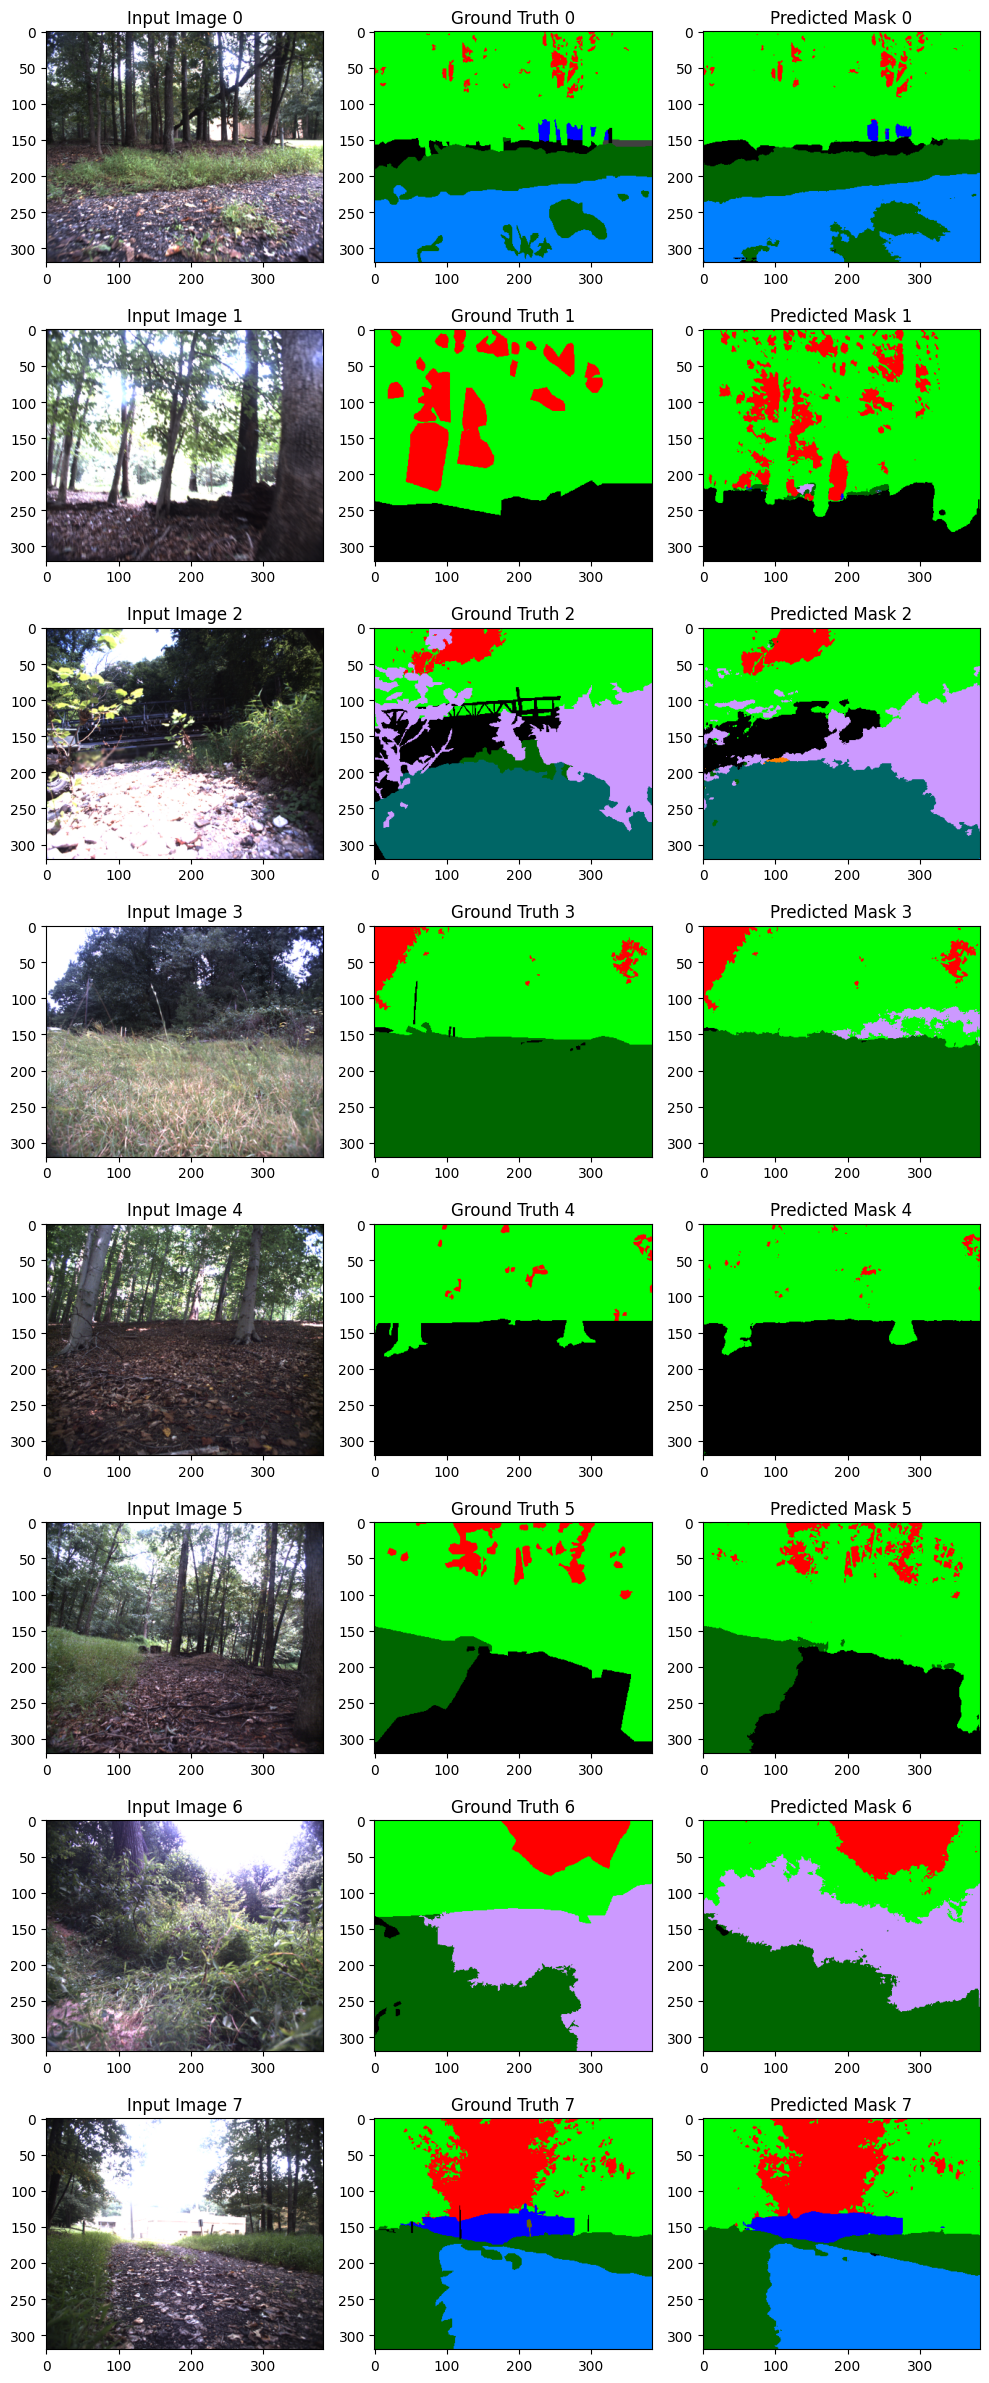

In [24]:
# Get one batch from test dataset
for test_img, test_mask in test_dataset.take(1):
    pred_mask = best_model.predict(test_img)
    pred_mask = np.argmax(pred_mask, axis=-1)  # Convert softmax to class labels

    print("Unique values in predicted mask:", np.unique(pred_mask))
    print("Unique values in test mask:", np.unique(test_mask))
    break  # Process only one batch

# Convert to numpy array for easy indexing
color_array = np.array([color_map[key] for key in sorted(color_map.keys())], dtype=np.uint8)

# Function to apply color map to label mask
def apply_color_map(label_mask):
    """Convert label mask (H, W) to a color image (H, W, 3)."""
    return color_array[label_mask]

# Ensure predicted mask only contains valid labels
valid_labels = np.array(list(color_map.keys()))
pred_mask = np.where(np.isin(pred_mask, valid_labels), pred_mask, 0)  # Map invalid classes to 0 (void)

# Convert grayscale masks to color
test_mask_color = np.array([apply_color_map(mask) for mask in test_mask])
pred_mask_color = np.array([apply_color_map(mask) for mask in pred_mask])

# Number of images in the batch
batch_size = test_img.shape[0]

# Display results for entire batch
fig, axes = plt.subplots(batch_size, 3, figsize=(10, batch_size * 3))

for i in range(batch_size):
    axes[i, 0].imshow(test_img[i])
    axes[i, 0].set_title(f"Input Image {i}")

    axes[i, 1].imshow(test_mask_color[i])
    axes[i, 1].set_title(f"Ground Truth {i}")

    axes[i, 2].imshow(pred_mask_color[i])
    axes[i, 2].set_title(f"Predicted Mask {i}")

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on Test Set
test_loss, test_acc, test_mean_iou = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Mean IoU: {test_mean_iou:.4f}")


93/93 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.8067 - loss: 1.0933 - mean_io_u: 0.2618
Test Accuracy: 0.7995
Test Mean IoU: 0.2573


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Unique values in predicted mask: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 16 17 18 19 20 21 22 24]
Unique values in test mask: [ 0  3  4  6  7 10 11 12 17 20]


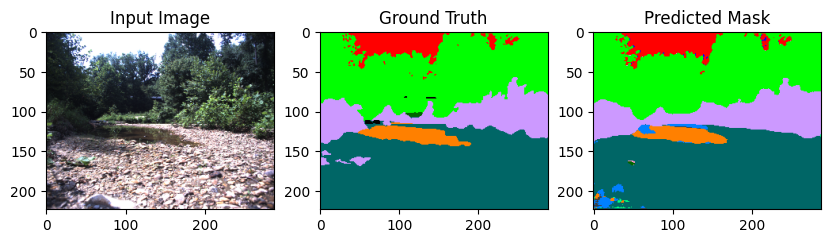

In [ ]:
# Test on a Sample Image
for test_img, test_mask in test_dataset.take(1):  # Take first test batch
    pred_mask = model.predict(test_img)
    pred_mask = np.argmax(pred_mask, axis=-1)  # Convert from one-hot to class indices
    print("Unique values in predicted mask:", np.unique(pred_mask))
    print("Unique values in test mask:", np.unique(test_mask))
    break  # Only process one batch

# Convert to numpy array for easy indexing
color_array = np.array([color_map[key] for key in sorted(color_map.keys())], dtype=np.uint8)

# Function to apply color map to label mask
def apply_color_map(label_mask):
    """Convert label mask (H, W) to a color image (H, W, 3)."""
    return color_array[label_mask]

# Ensure predicted mask only contains valid labels
valid_labels = np.array(list(color_map.keys()))
pred_mask = np.where(np.isin(pred_mask, valid_labels), pred_mask, 0)  # Map invalid classes to 0 (void)

# Convert grayscale mask to color
test_mask_color = apply_color_map(test_mask)
pred_mask_color = apply_color_map(pred_mask)

n=5

# Display Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1); plt.imshow(test_img[n]); plt.title("Input Image")
plt.subplot(1, 3, 2); plt.imshow(test_mask_color[n]); plt.title("Ground Truth")
plt.subplot(1, 3, 3); plt.imshow(pred_mask_color[n]); plt.title("Predicted Mask")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define how many images to visualize
num_images = 8  # Change this number based on how many you want to display

# Take one batch from the dataset
for test_img, test_mask in test_dataset.take(1):
    pred_mask = model.predict(test_img)
    pred_mask = np.argmax(pred_mask, axis=-1)  # Convert from one-hot to class indices

    # Ensure predicted mask only contains valid labels
    valid_labels = np.array(list(color_map.keys()))
    pred_mask = np.where(np.isin(pred_mask, valid_labels), pred_mask, 0)  # Map invalid classes to 0 (void)

    # Convert grayscale mask to color
    test_mask_color = np.array([apply_color_map(mask) for mask in test_mask])
    pred_mask_color = np.array([apply_color_map(mask) for mask in pred_mask])

    # Display Results
    fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4))  # Adjust grid size

    for i in range(num_images):
        axes[i, 0].imshow(test_img[i])
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(test_mask_color[i])
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_mask_color[i])
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()
    break  # Only process one batch
